Importing Dataset
Before MLDatasets, make sure it is downloaded via Julia ], add MLDatasets

In [1]:
using MLDatasets

# https://juliaml.github.io/MLDatasets.jl/stable/datasets/CIFAR10/#MLDatasets.CIFAR10.traintensor

# load full training set as float 32, otherwise get warnings in train
train_x, train_y = CIFAR10.traindata(Float32) # full traindatatset 50000 training images + 10 classes
# boobs
# load full test set
test_x, test_y = CIFAR10.testdata(Float32) # full test dataset 10000 test images + 10 classes

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294]

Float32[0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451]

Float32[0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255]

Float32[0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118]

Float32[0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374]

Float32[0.92156863 0.93333334 

Import libraries 

In [2]:
using Flux
using Flux: Data.DataLoader
using Flux: @epochs, onehotbatch, crossentropy, Momentum, update!, onecold, ADAM
using Plots
using CUDA
using Statistics


(process:6360): GLib-GIO-WARNING **: 22:26:30.667: Unexpectedly, UWP app `Evernote.Evernote_10.20.4.0_x86__q4d96b2w5wcc2' (AUMId `Evernote.Evernote_q4d96b2w5wcc2!Evernote') supports 1 extensions but has no verbs
┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("C:\\Users\\Yishi\\.julia\\packages\\Plots\\Di0Qb\\src\\backends\\hdf5.jl", 36, UndefVarError(:Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000001f54a81, Ptr{Nothing} @0x0000000001fe1574, Ptr{Nothing} @0x0000000001fe1ae2, Ptr{Nothing} @0x0000000001fe16f4, Ptr{Nothing} @0x0000000001fe2048, Ptr{Nothing} @0x0000000001fe2c85, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x0000000001fff287, Ptr{Nothing} @0x0000000001fffaca, Ptr{Nothing} @0x0000000001fffdc1, Ptr{Nothing} @0x0000000001fffdc1, Ptr{Nothing} @0x0000000002000d0f, Ptr{Nothing} @0x000000000f794dfb, Ptr{Nothing} @0x000000000f794a1f, Ptr{Nothing} @0x000000000f2450c8, Ptr{N

Plot an Image with a Title and vlaues

In [ ]:
CIFAR10.trainlabels(1)

In [ ]:
CIFAR10.classnames()

In [ ]:
CIFAR10.classnames()[CIFAR10.trainlabels(1) + 1]

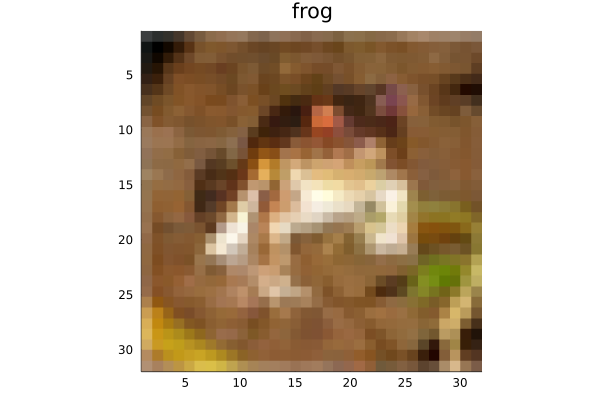


(process:22076): GLib-GIO-WARNING **: 12:50:37.695: Unexpectedly, UWP app `Evernote.Evernote_10.20.4.0_x86__q4d96b2w5wcc2' (AUMId `Evernote.Evernote_q4d96b2w5wcc2!Evernote') supports 1 extensions but has no verbs


In [5]:
plot(CIFAR10.convert2image(CIFAR10.traintensor(1)),  title = CIFAR10.classnames()[CIFAR10.trainlabels(1) + 1])

Image info with Numerical Values

In [ ]:
CIFAR10.traintensor(Float32, 1:50) # original values are gray scale 32 x 32 image size with RGB (3)

Train 50 Dataset (Demonstration)
Conv(filter, in => out, σ = identity; stride = 1, pad = 0, dilation = 1, groups = 1, [bias, weight, init])

First Group

In [5]:
layer1 = Flux.Conv((3,3), 3=>32, relu, pad=SamePad()) # num of paras = 3*(3*3)*32 = 864
layer2 = Flux.BatchNorm(32) # this does not change when a batch is 1
layer3 = Flux.Conv((3,3), 32=>32, relu, pad=SamePad())
layer4 = Flux.BatchNorm(32)
layer5 = Flux.MaxPool((2, 2))

MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2))

Second Group

In [6]:
layer6 = Flux.Conv((3,3), 32=>64, relu, pad=SamePad()) # num of paras = 3*(3*3)*32 = 864
layer7 = Flux.BatchNorm(64) # this does not change when a batch is 1
layer8 = Flux.Conv((3,3), 64=>64, relu, pad=SamePad())
layer9 = Flux.BatchNorm(64)
layer10 = Flux.MaxPool((2, 2))

MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2))

Full Connection

In [7]:
# before this Flatten is called

layer11 = Flux.Dropout(0.2)
layer12 = Flux.Dense(4096, 256, relu) # (8*8)*64 features
layer13 = Flux.Dense(256, 10)

# layer13 goes to softmax

Dense(256, 10)

In [8]:
r1 = layer1(CIFAR10.traintensor(Float32, 1:50))

32×32×32×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0969776  0.0434189  0.0364313  0.0489453  …  0.324497   0.302111  0.286088
 0.102734   0.0454148  0.0537255  0.0972659     0.386155   0.34832   0.346381
 0.104291   0.0666055  0.102005   0.165726      0.378157   0.336304  0.328702
 0.132332   0.128766   0.171887   0.214707      0.387194   0.358057  0.320585
 0.181786   0.192861   0.232657   0.241114      0.386135   0.383735  0.330564
 0.23212    0.256717   0.266879   0.247199   …  0.38326    0.404321  0.347883
 0.269527   0.279463   0.272448   0.240622      0.383435   0.396359  0.347493
 0.286409   0.281709   0.25601    0.224239      0.363396   0.376069  0.336775
 0.296339   0.281305   0.23938    0.226449      0.332174   0.348781  0.322896
 0.294105   0.259804   0.240172   0.250143      0.301211   0.321284  0.318416
 0.268659   0.243519   0.240836   0.258482   …  0.306942   0.313756  0.313192
 0.257674   0.243619   0.233848   0.239892      0.312874   0.310083  0.311922
 0.278658   0.2438

In [9]:
r2 = layer2(r1)

32×32×32×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0969771  0.0434187  0.0364311  0.048945   …  0.324496   0.30211   0.286086
 0.102733   0.0454146  0.0537252  0.0972654     0.386153   0.348319  0.346379
 0.10429    0.0666052  0.102005   0.165725      0.378155   0.336302  0.3287
 0.132331   0.128766   0.171886   0.214706      0.387192   0.358055  0.320583
 0.181786   0.192861   0.232656   0.241113      0.386133   0.383733  0.330562
 0.232118   0.256715   0.266877   0.247198   …  0.383258   0.404319  0.347882
 0.269526   0.279462   0.272446   0.240621      0.383433   0.396357  0.347491
 0.286408   0.281708   0.256009   0.224238      0.363394   0.376068  0.336773
 0.296337   0.281303   0.239379   0.226447      0.332173   0.348779  0.322895
 0.294103   0.259802   0.240171   0.250142      0.30121    0.321282  0.318414
 0.268658   0.243517   0.240835   0.25848    …  0.30694    0.313754  0.31319
 0.257673   0.243618   0.233847   0.239891      0.312872   0.310082  0.311921
 0.278657   0.24387  

In [10]:
r3 = layer3(r2)

32×32×32×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0046426  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.010815
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.00472479
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.00329055
 0.0  0.0  0.0        0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.00607631
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0124265
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0220618
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0302816
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0290964
 0.0  0.0  0.0        0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0205436
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0180527
 0.0  0.0  0.0        0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 

In [11]:
r4 = layer4(r3)

32×32×32×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.00464258  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.010815
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.00472477
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.00329053
 0.0  0.0  0.0         0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.00607628
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0124264
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0220617
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0302815
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0290963
 0.0  0.0  0.0         0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0205435
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0180526
 0.0  0.0  0.0         0.0  0.0  0.0     0.0  0.0  0

In [12]:
r5 = layer5(r4)

16×16×32×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.00464258  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.010815
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.00607628
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0220617
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0302815
 0.0  0.0         0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0205435
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.02334
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0173742
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0133447
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.00816281
 0.0  0.0         0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0183093
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0162266
 0.0  0.0         0.0  0.0  0.0  0.0     0.0  0.0

In [13]:
r6 = layer6(r5)

16×16×64×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0        0.0        0.0         …  0.0         0.0         0.016735
 0.0        0.0        0.0            0.0247593   0.0062182   0.0906131
 0.0        0.0246267  0.0            0.0188356   0.0244815   0.117281
 0.0        0.0258075  0.00425918     0.0255812   0.0174342   0.104682
 0.0        0.0344002  0.00724609     0.0299216   0.00616139  0.0857071
 0.0        0.036256   0.0161089   …  0.0200408   0.0210649   0.0804639
 0.0        0.0373223  0.0194862      0.0414305   0.0240388   0.0689792
 0.0        0.0310903  0.0112693      0.0508212   0.0256611   0.0630403
 0.0        0.036638   0.0278269      0.036752    0.0313326   0.0669268
 0.0        0.0499751  0.0320534      0.027757    0.0240462   0.0645572
 0.0        0.0500329  0.0306721   …  0.0146014   0.0320971   0.0756277
 0.0        0.0506157  0.010282       0.00302423  0.0380158   0.0714922
 0.0        0.043406   0.0373423      0.0196668   0.032027    0.0541306
 0.0        0.0440528

In [14]:
r7 = layer7(r6)

16×16×64×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0       0.0        0.0         …  0.0         0.0         0.016735
 0.0       0.0        0.0            0.0247592   0.00621817  0.0906127
 0.0       0.0246266  0.0            0.0188355   0.0244813   0.11728
 0.0       0.0258074  0.00425915     0.0255811   0.0174341   0.104682
 0.0       0.0344     0.00724605     0.0299214   0.00616135  0.0857066
 0.0       0.0362558  0.0161088   …  0.0200407   0.0210648   0.0804635
 0.0       0.0373222  0.0194861      0.0414303   0.0240387   0.0689788
 0.0       0.0310902  0.0112692      0.050821    0.025661    0.0630399
 0.0       0.0366379  0.0278267      0.0367518   0.0313324   0.0669265
 0.0       0.0499748  0.0320532      0.0277569   0.0240461   0.0645568
 0.0       0.0500327  0.0306719   …  0.0146013   0.0320969   0.0756273
 0.0       0.0506154  0.010282       0.00302422  0.0380156   0.0714918
 0.0       0.0434058  0.0373421      0.0196667   0.0320268   0.0541303
 0.0       0.0440526  0.0439388    

In [15]:
r8 = layer8(r7)

16×16×64×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0060885   0.0         0.0        …  0.0         0.0         0.0  0.0
 0.0213257   0.0114949   0.0124417     0.00839982  0.00991275  0.0  0.0
 0.0192815   0.0173314   0.0           0.0         0.0         0.0  0.0
 0.0168006   0.0111783   0.0           0.0         0.0         0.0  0.0
 0.0156543   0.00378066  0.0           0.0         0.0         0.0  0.0
 0.00988783  0.0         0.0        …  0.0         0.0         0.0  0.0
 0.013074    0.00662093  0.0           0.0         0.0         0.0  0.0
 0.0144813   0.0         0.0           0.0         0.0         0.0  0.0
 0.01529     0.0116573   0.0           0.0         0.0         0.0  0.0
 0.0153973   0.0         0.0           0.0         0.0         0.0  0.0
 0.0174988   0.00627098  0.0        …  0.0         0.0         0.0  0.0
 0.0113909   0.00439207  0.0           0.0         0.0         0.0  0.0
 0.00818572  0.00310649  0.0           0.0         0.0         0.0  0.0
 0.00201256  0.002

In [16]:
r9 = layer9(r8)

16×16×64×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.00608847  0.0         0.0        …  0.0         0.0        0.0  0.0
 0.0213256   0.0114949   0.0124416     0.00839978  0.0099127  0.0  0.0
 0.0192814   0.0173313   0.0           0.0         0.0        0.0  0.0
 0.0168005   0.0111783   0.0           0.0         0.0        0.0  0.0
 0.0156543   0.00378065  0.0           0.0         0.0        0.0  0.0
 0.00988778  0.0         0.0        …  0.0         0.0        0.0  0.0
 0.0130739   0.0066209   0.0           0.0         0.0        0.0  0.0
 0.0144812   0.0         0.0           0.0         0.0        0.0  0.0
 0.0152899   0.0116572   0.0           0.0         0.0        0.0  0.0
 0.0153972   0.0         0.0           0.0         0.0        0.0  0.0
 0.0174987   0.00627095  0.0        …  0.0         0.0        0.0  0.0
 0.0113909   0.00439205  0.0           0.0         0.0        0.0  0.0
 0.00818568  0.00310647  0.0           0.0         0.0        0.0  0.0
 0.00201255  0.00284436  0.0   

In [17]:
r10 = layer10(r9)

8×8×64×50 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0213256   0.0124416  0.0106786   …  0.00725983  0.0  0.0099127  0.0
 0.0192814   0.0        0.0            0.0         0.0  0.0        0.0
 0.0156543   0.0        0.0            0.0         0.0  0.0        0.0
 0.0144812   0.0        0.00984505     0.0         0.0  0.0        0.0
 0.0153972   0.0        0.0            0.0         0.0  0.0        0.0
 0.0174987   0.0        0.0         …  0.0         0.0  0.0        0.0
 0.00818568  0.0        0.0            0.0         0.0  0.0        0.0
 0.00911856  0.0        0.0            0.0         0.0  0.0        0.0

[:, :, 2, 1] =
 0.0         0.0         0.000843159  …  0.0        0.0        0.00255151
 0.0         0.00763616  0.0237664       0.0296047  0.0104265  0.0430004
 0.00343101  0.0142793   0.0129844       0.0561812  0.0377038  0.0233898
 0.00455987  0.0126818   0.0             0.0498023  0.032576   0.0240541
 0.00963001  0.00758896  0.0             0.0403262  0.0339011  0.0275635
 0.011

In [18]:
full_1 = Flux.flatten(r10)

4096×50 Matrix{Float32}:
 0.0213256   0.0323287  0.0679116   …  0.0174723   0.0434598   0.0465742
 0.0192814   0.0279761  0.0454535      0.00830774  0.0257241   0.0286513
 0.0156543   0.0        0.0155058      0.00209551  0.00893702  0.0270157
 0.0144812   0.0219497  0.00355154     0.0         0.00888444  0.0168811
 0.0153972   0.0151887  0.0083667      0.0         0.0160856   0.0196504
 0.0174987   0.0        0.0292432   …  0.0         0.018614    0.0201328
 0.00818568  0.0        0.0218696      0.0         0.0142693   0.0197748
 0.00911856  0.0        0.0            0.0         0.0         0.0
 0.0124416   0.0        0.0148151      0.0         0.0         0.0314274
 0.0         0.0        0.0            0.0         0.0         0.0
 0.0         0.0        0.0         …  0.0         0.0         0.0
 0.0         0.0        0.0            0.0         0.0         0.0
 0.0         0.0        0.0            0.0         0.0         0.0
 ⋮                                  ⋱                   

In [19]:
full_2 = layer11(full_1)

4096×50 Matrix{Float32}:
 0.0213256   0.0323287  0.0679116   …  0.0174723   0.0434598   0.0465742
 0.0192814   0.0279761  0.0454535      0.00830774  0.0257241   0.0286513
 0.0156543   0.0        0.0155058      0.00209551  0.00893702  0.0270157
 0.0144812   0.0219497  0.00355154     0.0         0.00888444  0.0168811
 0.0153972   0.0151887  0.0083667      0.0         0.0160856   0.0196504
 0.0174987   0.0        0.0292432   …  0.0         0.018614    0.0201328
 0.00818568  0.0        0.0218696      0.0         0.0142693   0.0197748
 0.00911856  0.0        0.0            0.0         0.0         0.0
 0.0124416   0.0        0.0148151      0.0         0.0         0.0314274
 0.0         0.0        0.0            0.0         0.0         0.0
 0.0         0.0        0.0         …  0.0         0.0         0.0
 0.0         0.0        0.0            0.0         0.0         0.0
 0.0         0.0        0.0            0.0         0.0         0.0
 ⋮                                  ⋱                   

In [20]:
full_3 = layer12(full_2)

256×50 Matrix{Float32}:
 0.0         0.0        0.0         …  0.0        0.0         0.0
 0.00141851  0.0        0.0            0.0        0.0         0.0
 0.0         0.0221241  0.0447978      0.0        0.00794506  0.0247616
 0.0         0.0        0.0337142      0.0158565  0.026595    0.0317055
 0.0         0.0        0.0            0.0        0.0         0.0
 0.0         0.0        0.0         …  0.0        0.0         0.0
 0.0185988   0.0128275  0.0            0.0        0.0134492   0.00674952
 0.0421918   0.0191709  0.0393038      0.0229618  0.0314839   0.0284146
 0.0442003   0.0463822  0.047028       0.0413654  0.0598884   0.0495753
 0.120492    0.171596   0.158339       0.128102   0.177859    0.226552
 0.0753182   0.111876   0.0438921   …  0.0562978  0.0882963   0.084958
 0.0         0.016984   0.0213063      0.0137026  0.0111219   0.0
 0.134586    0.147685   0.114821       0.0596787  0.194203    0.192194
 ⋮                                  ⋱                         
 0.0     

In [21]:
result = layer13(full_3)

10×50 Matrix{Float32}:
  0.00246062  -0.0408516  -0.05348    -0.00030826  …  -0.00729548  -0.0556747
 -0.105105    -0.142739   -0.119845   -0.0878498      -0.145775    -0.143043
 -0.109233    -0.195953   -0.163126   -0.0825592      -0.157275    -0.193178
  0.0225893    0.0433177   0.0519299   0.00569978      0.0683785    0.0702988
  0.0219489    0.0416605  -0.0200106   0.0323534       0.105367     0.0942975
 -0.0906793   -0.143021   -0.145597   -0.0808856   …  -0.16019     -0.206405
  0.00126464   0.036865    0.0276185   0.0210441      -0.0151678    0.0223949
 -0.0775503   -0.0982708  -0.0425103  -0.043529       -0.11006     -0.0804756
  0.0544231    0.108732    0.0749598   0.0549573       0.105398     0.116052
 -0.0948606   -0.0741374  -0.0732941  -0.0851937      -0.15097     -0.129077

In [22]:
softmax(result) # check the 6th has highest value (those values are probabilities)

10×50 Matrix{Float32}:
 0.103886   0.100102   0.0989895  …  0.10284    0.10344    0.0988407
 0.0932916  0.0904055  0.0926333     0.09446    0.0900632  0.0905716
 0.0929072  0.0857204  0.0887096     0.0932993  0.0890334  0.0861428
 0.105998   0.108893   0.109994      0.103337   0.111571   0.11211
 0.105931   0.108712   0.102359      0.107334   0.115775   0.114833
 0.0946471  0.09038    0.0902782  …  0.0929485  0.0887743  0.0850109
 0.103762   0.108192   0.107352      0.10368    0.102629   0.106866
 0.0958979  0.0945163  0.100081      0.0975366  0.0933379  0.0964195
 0.109427   0.116254   0.112556      0.10788    0.115779   0.117359
 0.0942522  0.0968251  0.0970474     0.0966853  0.0895965  0.0918455

Creating CNN

Simple Model

In [3]:
model = Flux.Chain(
    # input size = 32*32*3*1 

    Flux.Conv((3,3), 3=>32, relu, pad=SamePad()),
    Flux.BatchNorm(32), # should be the size of the channel dimension in your data
    Flux.Conv((3,3), 32=>32, relu, pad=SamePad()),
    Flux.BatchNorm(32),
    Flux.MaxPool((2, 2)), # 16*16*32*1

    Flux.flatten, 
    Flux.Dropout(0.2),

    Flux.Dense(8192, 64, relu), # (16*16)*32 features
    Flux.Dense(64, 10),
    softmax
    ) |> gpu

Chain(Conv((3, 3), 3=>32, relu), BatchNorm(32), Conv((3, 3), 32=>32, relu), BatchNorm(32), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dropout(0.2), Dense(8192, 64, relu), Dense(64, 10), softmax)

Full Model

In [61]:
model = Flux.Chain(
    # input size = 32*32*3*1 

    Flux.Conv((3,3), 3=>32, relu, pad=SamePad()),
    Flux.BatchNorm(32), # should be the size of the channel dimension in your data
    Flux.Conv((3,3), 32=>32, relu, pad=SamePad()),
    Flux.BatchNorm(32),
    Flux.MaxPool((2, 2)), # 16*16*32*1

    Flux.Conv((3,3), 32=>64, relu, pad=SamePad()), # 16*16*64*1
    Flux.BatchNorm(64), # should be the size of the channel dimension in your data
    Flux.Conv((3,3), 64=>64, relu, pad=SamePad()),
    Flux.BatchNorm(64),
    Flux.MaxPool((2, 2)), # 8*8*64

    Flux.Conv((3,3), 64=>128, relu, pad=SamePad()), # 8*8*128*1
    Flux.BatchNorm(128), # should be the size of the channel dimension in your data
    Flux.Conv((3,3), 128=>128, relu, pad=SamePad()),
    Flux.BatchNorm(128),
    Flux.MaxPool((2, 2)), # 4*4*128*1

    Flux.flatten, 
    Flux.Dropout(0.2),

    Flux.Dense(2048, 516, relu), # (4*4)*128 features
    Flux.Dense(516, 10),
    softmax
    ) |> gpu

Chain(Conv((3, 3), 3=>32, relu), BatchNorm(32), Conv((3, 3), 32=>32, relu), BatchNorm(32), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>64, relu), BatchNorm(64), Conv((3, 3), 64=>64, relu), BatchNorm(64), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 64=>128, relu), BatchNorm(128), Conv((3, 3), 128=>128, relu), BatchNorm(128), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dropout(0.2), Dense(2048, 516, relu), Dense(516, 10), softmax)

VGG16 Model : Consuming a lot of Memory (RAM)

In [25]:
model = Chain
(
  Conv((3, 3), 3 => 64, relu, pad=(1, 1), stride=(1, 1)), 
  BatchNorm(64),
  Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  MaxPool((2,2)),

  Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  MaxPool((2,2)),

  Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  MaxPool((2,2)),

  Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  MaxPool((2,2)),

  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  MaxPool((2,2)),

  x -> reshape(x, :, size(x, 4)),
  Dense(512, 4096, relu),  
  Dropout(0.5),

  Dense(4096, 4096, relu),
  Dropout(0.5),
  
  Dense(4096, 10),
  softmax
  ) |> gpu

(Conv((3, 3), 3=>64, relu), BatchNorm(64), Conv((3, 3), 64=>64, relu), BatchNorm(64), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 64=>128, relu), BatchNorm(128), Conv((3, 3), 128=>128, relu), BatchNorm(128), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 128=>256, relu), BatchNorm(256), Conv((3, 3), 256=>256, relu), BatchNorm(256), Conv((3, 3), 256=>256, relu), BatchNorm(256), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 256=>512, relu), BatchNorm(512), Conv((3, 3), 512=>512, relu), BatchNorm(512), Conv((3, 3), 512=>512, relu), BatchNorm(512), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 512=>512, relu), BatchNorm(512), Conv((3, 3), 512=>512, relu), BatchNorm(512), Conv((3, 3), 512=>512, relu), BatchNorm(512), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), var"#74#75"(), Dense(512, 4096, relu), Dropout(0.5), Dense(4096, 4096, relu), Dropout(0.5), Dense(4096, 10), NNlib.softmax)

ResNet Model: Must Run All Cells 

In [3]:
struct conv_skip
    conv::Chain
end |> gpu
conv_skip(input_filter, filter) = conv_skip(shortcut(input_filter, filter))

conv_skip

In [4]:
function (op::conv_skip)(x, y)
    z = op.conv(y)
    return x + z
end

In [5]:
identityBlock(input_filter, filter) = Chain(
    # layer 1
    Conv((3, 3), input_filter => filter, pad=(1, 1), stride=(1, 1)), # pad=(1, 1) is same
    BatchNorm(filter, relu),

    # layer 2
    Conv((3, 3), filter => filter, pad=(1, 1), stride=(1, 1)), # pad=(1, 1) is same
    BatchNorm(filter, relu),
    
    # layer 3
    Conv((3, 3), filter => filter, pad=(1, 1), stride=(1, 1)), # pad=(1, 1) is same
    BatchNorm(filter),    
) |> gpu

identityBlock (generic function with 1 method)

In [6]:
shortcut(input_filter, filter) = Chain(
  Conv((3,3), input_filter => filter, stride=(1,1)), # pad=0 is valid
  BatchNorm(filter),
) |> gpu

shortcut (generic function with 1 method)

In [7]:
convBlock(input_filter, filter) = Chain(
    # layer 1
    Conv((3, 3), input_filter => filter, pad=(1, 1), stride=(1, 1)), # pad=(1, 1) is same
    BatchNorm(filter, relu),

    # layer 2
    Conv((3, 3), filter => filter, pad=(1, 1), stride=(1, 1)), # pad=(1, 1) is same
    BatchNorm(filter, relu),
    
    # layer 3
    Conv((3, 3), filter => filter, stride=(1, 1)), # pad=0 is valid
    BatchNorm(filter),
) |> gpu

convBlock (generic function with 1 method)

In [8]:
model = Chain(
    # input size = 32*32*3*1 
    
    # prepare for ResNet
    Conv((7,7), 3=>64, stride=(2,2)), # output = 13*13*64 : params = 3*7*7*64: 
    BatchNorm(64, relu),
    MaxPool((3,3), pad=(1,1), stride=(2,2)), # output = 7*7*64
    
    # ResNet 18 layer: The simplest "ResNet"-type connection is just SkipConnection(layer, +)
    SkipConnection(convBlock(64, 64), conv_skip(64, 64)), # output = 5*5*64

    # *identityBlock must have the same input_filter and filter size. Otherwiese it gives error identityBlock(64, 128) -> error
    SkipConnection(identityBlock(64, 64), +), # output = 5*5*64
    SkipConnection(identityBlock(64, 64), +), # output = 5*5*64
     
    SkipConnection(convBlock(64, 128), conv_skip(64, 128)), # output = 3*3*128
    SkipConnection(identityBlock(128, 128), +), # output = 3*3*128
    SkipConnection(identityBlock(128, 128), +), # output = 3*3*128

    # full connections layers
    MaxPool((2, 2)), # 1*1*128
    Flux.flatten, 
    Dropout(0.3),    
    Dense(128, 1024, relu), 
    Dropout(0.3),
    Dense(1024, 10),
    
    softmax
) |> gpu


Chain(Conv((7, 7), 3=>64), BatchNorm(64, λ = relu), MaxPool((3, 3), pad = (1, 1), stride = (2, 2)), SkipConnection(Chain(Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64)), conv_skip(Chain(Conv((3, 3), 64=>64), BatchNorm(64)))), SkipConnection(Chain(Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64)), +), SkipConnection(Chain(Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64, λ = relu), Conv((3, 3), 64=>64), BatchNorm(64)), +), SkipConnection(Chain(Conv((3, 3), 64=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128)), conv_skip(Chain(Conv((3, 3), 64=>128), BatchNorm(128)))), SkipConnection(Chain(Conv((3, 3), 128=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128, λ = relu), Conv((3, 3), 128=>128), BatchNorm(128

Training Data

Data Preparation ------------------------------

In [9]:
# without CUDA (CPU)

# MLDatasets returns UInt8 thus convert it to Float64
train_x = Array{Float32}(train_x) # without converting, it gives errors, especially, the labels
test_x = Array{Float32}(test_x)

# construct one-hot vectors from labels
train_y = onehotbatch(train_y, 0:9) # https://fluxml.ai/Flux.jl/stable/data/onehot/
test_y = onehotbatch(test_y, 0:9) # This is a sparse matrix, which stores just a Vector{UInt32} containing the indices of the nonzero elements.

train_data = DataLoader(train_x, train_y, batchsize=50, shuffle=true) # 1000 blocks
test_data = DataLoader(test_x, test_y, batchsize=10) # 100 blocks


# CUDA tensor (GPU)

# train_x_tensor = permutedims(train_x, [1, 2, 3, 4])
# train_y_onehot = onehotbatch(train_y, 0:9)

# test_x_tensor = permutedims(test_x, [1, 2, 3, 4])
# test_y_onehot = onehotbatch(test_y, 0:9)

# cu_train_x_tensor = cu(train_x_tensor)
# cu_train_y_onehot = cu(train_y_onehot)

# cu_test_x_tensor = cu(test_x_tensor)
# cu_test_y_onehot = cu(test_y_onehot)

# train_data = DataLoader(cu_train_x_tensor, cu_train_y_onehot, batchsize=50, shuffle=true) # 1000 blocks
# test_data = DataLoader(cu_test_x_tensor, cu_test_y_onehot, batchsize=10) # 100 blocks

println("conversion is done")

conversion is done


Optimizer ------------------------------

In [10]:
lr = 0.001 # learning_rate
opt = ADAM(lr, (0.9, 0.999)) |> gpu

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

Loss and Accuracy ------------------------------

In [11]:
# loss is for softmax
loss(x, y) = sum(crossentropy(model(x), y))  # when this loss is called, assume x and y are given
accuracy(x, y) = mean(onecold(model(x), 0:9) .== onecold(y, 0:9))  # when this accuracy is called, assume x and y are given

# for plotting
train_losses = []
test_losses = []
train_acces = []
test_acces = []

Any[]

Callbacks ------------------------------

In [12]:
function loss_all(data_loader)
    sum([loss(x, y) for (x,y) in data_loader]) / length(data_loader) 
    # using sum twice: 
    # first sum in loss(x, y) is for batched values (each batch 50 images)
    # second sum 2 lines aboive is for all batches (1000 batches)
end

function acc(data_loader)         
    sum([accuracy(x, y) for (x,y) in data_loader]) / length(data_loader) 
end

acc (generic function with 1 method)

Training ------------------------------

In [13]:
epochs = 2 # CPU takes a lot of time and memory for each epoch
# epochs = 50 # GPU must be on

for epoch = 1:epochs

    @info "epoch" epoch
	
	num = 0
	
	for (x, y) in train_data

		batch = (x, y)
		gs = gradient(params(model)) do
			l = loss(batch...)
		end

		num += 1
		fin = (num/length(train_data))*100

		print("...Training...")
		print(round(fin; digits=3))
		print("%\n")

		Flux.update!(opt, params(model), gs)
		
	end

	@info "...Calculating..."
	push!(train_losses, loss_all(train_data)),
    push!(test_losses, loss_all(test_data)),
    push!(train_acces, acc(train_data)),
    push!(test_acces, acc(test_data))  

	@show train_loss = loss_all(train_data)
	@show test_loss = loss_all(test_data)
	@show train_acc = acc(train_data)
	@show test_acc = acc(test_data)
end

┌ Info: epoch
│   epoch = 1
└ @ Main In[13]:6


...Training...0.1%
...Training...0.2%
...Training...0.3%
...Training...0.4%
...Training...0.5%
...Training...0.6%
...Training...0.7%
...Training...0.8%
...Training...0.9%
...Training...1.0%
...Training...1.1%
...Training...1.2%
...Training...1.3%
...Training...1.4%
...Training...1.5%
...Training...1.6%
...Training...1.7%
...Training...1.8%
...Training...1.9%
...Training...2.0%
...Training...2.1%
...Training...2.2%
...Training...2.3%
...Training...2.4%
...Training...2.5%
...Training...2.6%
...Training...2.7%
...Training...2.8%
...Training...2.9%
...Training...3.0%
...Training...3.1%
...Training...3.2%
...Training...3.3%
...Training...3.4%
...Training...3.5%
...Training...3.6%
...Training...3.7%
...Training...3.8%
...Training...3.9%
...Training...4.0%
...Training...4.1%
...Training...4.2%
...Training...4.3%
...Training...4.4%
...Training...4.5%
...Training...4.6%
...Training...4.7%
...Training...4.8%
...Training...4.9%
...Training...5.0%
...Training...5.1%
...Training...5.2%
...Training.

┌ Info: ...Calculating...
└ @ Main In[13]:28


train_loss = loss_all(train_data) = 1.153691f0
test_loss = loss_all(test_data) = 1.1833231f0
train_acc = acc(train_data) = 0.5919799999999998
test_acc = acc(test_data) = 0.5851000000000001


┌ Info: epoch
│   epoch = 2
└ @ Main In[13]:6


...Training...0.1%
...Training...0.2%
...Training...0.3%
...Training...0.4%
...Training...0.5%
...Training...0.6%
...Training...0.7%
...Training...0.8%
...Training...0.9%
...Training...1.0%
...Training...1.1%
...Training...1.2%
...Training...1.3%
...Training...1.4%
...Training...1.5%
...Training...1.6%
...Training...1.7%
...Training...1.8%
...Training...1.9%
...Training...2.0%
...Training...2.1%
...Training...2.2%
...Training...2.3%
...Training...2.4%
...Training...2.5%
...Training...2.6%
...Training...2.7%
...Training...2.8%
...Training...2.9%
...Training...3.0%
...Training...3.1%
...Training...3.2%
...Training...3.3%
...Training...3.4%
...Training...3.5%
...Training...3.6%
...Training...3.7%
...Training...3.8%
...Training...3.9%
...Training...4.0%
...Training...4.1%
...Training...4.2%
...Training...4.3%
...Training...4.4%
...Training...4.5%
...Training...4.6%
...Training...4.7%
...Training...4.8%
...Training...4.9%
...Training...5.0%
...Training...5.1%
...Training...5.2%
...Training.

Plotting ------------------------------

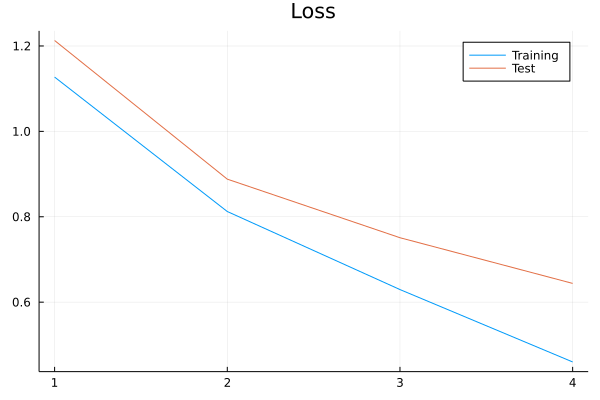

In [ ]:
plot([train_losses, test_losses], title = "Loss", label = ["Training" "Test"])

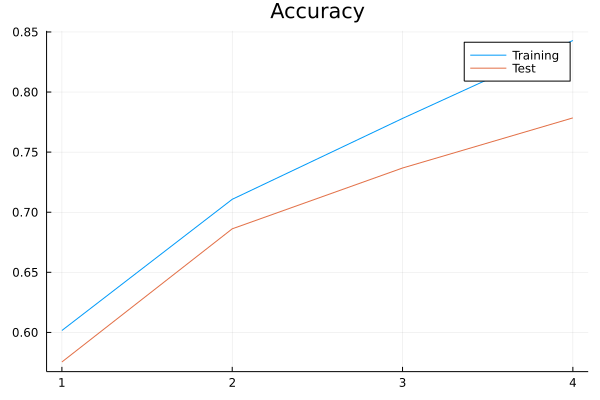

In [ ]:
plot([train_acces, test_acces], title = "Accuracy", label = ["Training" "Test"])